In [81]:
import os
import openai
import copy

from langchain.embeddings import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI


embeddings = OpenAIEmbeddings()
llm_name = "gpt-3.5-turbo"
llm = ChatOpenAI(model_name = llm_name, temperature = 0)

def get_completion(prompt, model = llm_name, temperature = 0):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(model = model,
                                            messages = messages,
                                            temperature = temperature)
    return response.choices[0].message['content']

# document folders
folder_names = ["articles", "patents", "lectures"]

In [82]:
# Converting Docx to Pdf for easier loading

import aspose.words as aw

for folder_name in folder_names:
    os.system(f"rm pdf_docs/{folder_name}/*.pdf")

    for file_name in os.listdir(os.path.join('docx_docs', folder_name)):
        try:
            a = aw.Document(os.path.join('docx_docs', folder_name, file_name))
            new_filename = ''.join(file_name.rsplit('.', 1)[:-1]) + '.pdf'
            a.save(os.path.join('pdf_docs', folder_name, new_filename))
        except:
            print(f"Could not convert document {file_name} from {folder_name}")

# TODO: Investigate why The Moon's Rotation 2.docx cannot be converted
os.remove("pdf_docs/articles/The Moon's Rotation 2.pdf")


Could not convert document The Moon's Rotation 2.docx from articles


In [169]:
# Loading PDF documents

from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

pages = []
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 5000)
for folder_name in folder_names:
    # TODO: Consider PDFLoader(splitPages = False)
    loader = PyPDFDirectoryLoader(path = f"pdf_docs/{folder_name}/")
    # TODO: Try other values for the text splitter chunk_size
    # TODO: Load without page splitting
    pages += loader.load_and_split(text_splitter = text_splitter)

In [178]:
# Removing watermarks from the data

strings_to_remove = ['Evaluation Only. Created with Aspose.Words. Copyright 2003-2023 Aspose Pty \nLtd.',
                    'Evaluation Only. Created with Aspose.Words. Copyright 2003-2023 Aspose Pty Ltd.',
                    'Evaluation Only. Created with Aspose.Words. Copyright 2003-2023 Aspose Pty',
                    'Created with an evaluation copy of Aspose.Words. To discover the full versions \nof our APIs please visit: https://products.aspose.com/words/',
                    'Created with an evaluation copy of Aspose.Words. To discover the full versions',
                    'Created with an evaluation copy of Aspose.Words. To discover the full \nversions of our APIs please visit: https://products.aspose.com/words/',
                    'Created with an evaluation copy of Aspose.Words. To discover the full versions of our \nAPIs please visit: https://products.aspose.com/words/',
                    'of our APIs please visit: https://products.aspose.com/words/',
                    'Created with an evaluation copy of Aspose.Words. To discover the \nfull versions of our APIs please visit: \nhttps://products.aspose.com/words/Evaluation',
                    'Only. Created with Aspose.Words. Copyright 2003-2023 \nAspose Pty Ltd.',
                    'Created with an evaluation copy of Aspose.Words. To discover the',
                    'full versions of our APIs please visit: \nhttps://products.aspose.com/words/',
                    ' of our \nAPIs please visit: https://products.aspose.com/words/'
                    ]

for i, page in enumerate(pages):
    for string in strings_to_remove:
        page.page_content = page.page_content.replace(string, '')
    assert not 'Created with Aspose' in page.page_content, f"Assert failed for page number {i} with content: {page.page_content} from file {page.metadata}"
    assert not 'Aspose' in page.page_content, f"Assert failed for page number {i} with content: {page.page_content} from file {page.metadata}"
    assert not 'Evaluation Only' in page.page_content, f"Assert failed for page number {i} with content: {page.page_content} from file {page.metadata}"
    assert not 'Copyright' in page.page_content, f"Assert failed for page number {i} with content: {page.page_content} from file {page.metadata}"
    assert not 'https://products.aspose.com/words/' in page.page_content, f"Assert failed for page number {i} with content: {page.page_content} from file {page.metadata}"

    page.metadata['document_name'] = ''.join(page.metadata['source'].split('/')[-1].rsplit('.', 1)[0])
    del page.metadata['source']

pages_backup = copy.deepcopy(pages)


page_content='A is an annular magnetic frame supported by the cross-bars or brackets B, provided with \nfeet C, upon which the machine rests. The interior of the annulus A is provided with a \nlarge number of projections or pole-pieces D. These may be formed or applied in a variety \nof ways—as, for example, by milling transverse grooves E.Owing to the very large number and small size of the poles and the spaces between them, \nI apply the exciting or field coils by winding an insulated conductor F zigzag through the \ngrooves, as shown in Fig. 5, carrying said wire around the annulus to form as many layers \nas is desired. In this way the pole-pieces D will be energized with alternately opposite \npolarity around the entire ring.For the armature I employ a spider or circular frame G on a driving-shaft H, mounted in \nbearings in the brackets B. This spider carries a ring J, turned down, except at its edges, \nto form a trough-like receptacle for a mass of fine annealed iron wires K, w

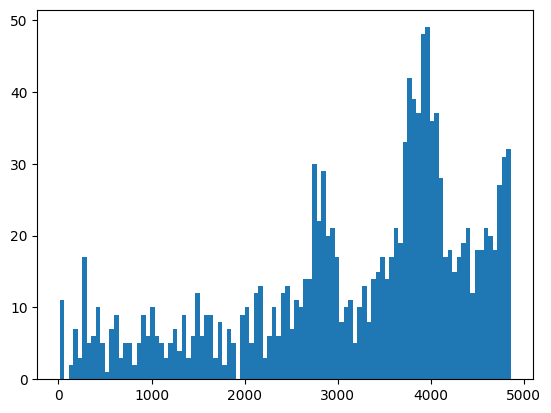

In [193]:
# Removing empty pages (leftover from images)

pages = [page for page in pages if len(page.page_content) > 0]

# TODO: Remove pages with less than 100 chars?

In [157]:
# Metadata parsing

import json

ascii_replace_dict = {'â€™': '’', 'â€œ': '“', 'â€': '”'}
def replace_non_ascii(s):
    for pair_k, pair_v in ascii_replace_dict.items():
        s = s.replace(pair_k, pair_v)
    return s

metadata_dict = {}
metadatas = json.load(open('metadata.json'))

for metadata in metadatas[2]['data']:
    if metadata['id'] in ['228', '413']:
        # These are duplicates, not needed
        continue
    key = ''.join(metadata['file_url'].split('/')[-1].rsplit('.', 1)[:-1])
    
    # Repalce non-ascii characters in key
    key = replace_non_ascii(key)
    
    # Make sure that there are no duplicate entries for the same document type
    if (key in metadata_dict.keys() and metadata['type'] == metadata_dict[key]['type']):
        print(key)
        print(metadata['id'])
    assert not (key in metadata_dict.keys() and metadata['type'] == metadata_dict[key]['type'])
    metadata_dict[key] = {key: value for key, value in metadata.items() if value is not None}

    # Replace non-ascii characters in file url
    # metadata_dict[key]['file_url'] = replace_non_ascii(metadata_dict[key]['file_url'])
    del metadata_dict[key]['file_url']
    for m_key, m_value in metadata_dict.items():
        if m_value is None:
            del metadata_dict[m_key]


In [158]:
# Adding metadata

for page in pages:
    assert page.metadata['document_name'] in metadata_dict.keys()
    page.metadata.update(metadata_dict[page.metadata['document_name']])

In [160]:
# Vectorstore creation

from langchain.vectorstores import Chroma

vectorstore = Chroma.from_documents(
    documents = pages,
    embedding = embeddings,
    persist_directory="./chroma_db"
)

In [66]:
# Vectorstore loading

vectorstore = Chroma(persist_directory="./chroma_db", embedding_function = embeddings)

In [161]:
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever

metadata_field_info = [
    AttributeInfo(
        name="document_name",
        description="Name of the source document",
        type="string",
    ),
    AttributeInfo(
        name="id",
        description="Document ID",
        type="string",
    ),
    AttributeInfo(
        name="title",
        description="Title of the document",
        type="string",
    ),
    AttributeInfo(
        name="date",
        description="When the document was created",
        type="string",
    ),
    AttributeInfo(
        name="register_num",
        description="Patent registration number",
        type="string",
    ),
    AttributeInfo(
        name="source",
        description="Source of the document",
        type="string",
    ),
    AttributeInfo(
        name="type",
        description="Type of the document - options are lecture, article, patent",
        type="string",
    )
]

document_content_description = "Document content"

retriever = SelfQueryRetriever.from_llm(
    llm = llm, 
    vectorstore = vectorstore,
    document_contents = document_content_description,
    metadata_field_info = metadata_field_info, 
    verbose=True
)

In [162]:
docs = retriever.get_relevant_documents("What lectures did Nikola Tesla give")

/home/jaksa/miniconda3/lib/python3.10/site-packages/langchain/chains/llm.py:278: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


query='Nikola Tesla' filter=Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='type', value='lecture') limit=None


In [167]:
[d.metadata['document_name'] for d in docs]

['Experiments With Alternate Currents of High Potential and High Frequency (lecture)',
 '7 On Electricity (lecture)',
 'Experiments With Alternating Currents of Very High Frequency and Their Application to Methods of Artificial Illumination (lecture)',
 '6 On Mechanical and Electrical Oscillators (lecture)']

In [ ]:
# Basic Retriever example

from langchain.chains import RetrievalQA

question = "How many poles shoul my electromotor have, and what should I do if I have the wrong number?"
qa_chain = RetrievalQA.from_chain_type(llm = llm, retriever = retriever)
print(qa_chain({"query": question}))

In [83]:
# Retriever with memory example

from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

memory = ConversationBufferMemory(memory_key = "chat_history", return_messages = True)
retriever = vectorstore.as_retriever()
qa = ConversationalRetrievalChain.from_llm(llm = llm, retriever = retriever, memory = memory)
question = input()
print(f"Question: {question}")
print(f"Answer: {qa({'question': question})['answer']}")
question = input()
print(f"Question: {question}")
print(f"Answer: {qa({'question': question})['answer']}")

Question: Did Nikola Tesla teach about light?
Answer: Yes, Nikola Tesla did discuss light in his lecture. He mentioned the electromagnetic theory of light and expressed his belief that electromagnetic waves, unless they had the frequency of true light waves, could not produce luminous effects. However, he believed that electrostatic waves could excite luminous radiation.
Question: When did he give that lecture and where?
Answer: Nikola Tesla gave the lecture discussing light at the Ellicot Club in Buffalo on January 12, 1897.
